### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import shap

### Dataset Loading and Cleaning

In [2]:
clients = pd.read_excel("../data/btUTgX.xlsx", index_col=0)

In [3]:
clients = clients[clients['tenure'] != 0]  # remove new customers
clients['TotalCharges'] = pd.to_numeric(clients['TotalCharges'], errors='coerce')
clients = clients.dropna(subset=['TotalCharges'])

In [4]:
original_clients = clients.copy()

### Feature Engineering

Additional features:
- InternetSecurity: combines OnlineSecurity and OnlineBackup (1 if any is Yes)
- Streaming: combines StreamingTV and StreamingMovies (1 if any is Yes)
- HouseholdComplexity: number of 'Yes' in Partner and Dependents (0 to 2)
- ChargesDiscrepancy: expected charges vs actual (MonthlyCharges * Tenure - TotalCharges)
- TechSupport_InternetSecurity: 1 if either TechSupport or InternetSecurity is active
- FinancialStrain: ratio of MonthlyCharges to tenure
- PaymentSafety: 1 if PaymentMethod contains "automatic", 0 otherwise

In [5]:
def simplify_services(df):
    df["InternetSecurity"] = df[["OnlineSecurity", "OnlineBackup", "DeviceProtection"]].apply(lambda row: 'Yes' if 'Yes' in row.values else 'No', axis=1)
    df["Streaming"] = df[["StreamingTV", "StreamingMovies"]].apply(lambda row: 'Yes' if 'Yes' in row.values else 'No', axis=1)
    df["HouseholdComplexity"] = df[["Partner", "Dependents"]].apply(lambda x: sum(val == 'Yes' for val in x), axis=1)
    df["ChargesDiscrepancy"] = df["MonthlyCharges"] * df["tenure"] - df["TotalCharges"]
    df["TechSupport_InternetSecurity"] = df[["TechSupport", "InternetSecurity"]].apply(lambda x: 'Yes' if 'Yes' in x.values else 'No', axis=1)
    df["FinancialStrain"] = df["MonthlyCharges"] / df["tenure"]
    automatic_pattern = re.compile(r"\bautomatic\b", re.IGNORECASE)
    df["PaymentSafety"] = df["PaymentMethod"].apply(lambda x: 1 if automatic_pattern.search(x) else 0)
    return df

clients = simplify_services(clients)

In [6]:
# Bin continuous features
clients["MonthlyChargesBin"] = pd.cut(clients["MonthlyCharges"], bins=[0, 35, 70, 105, 140], labels=False)
clients["TenureBin"] = pd.cut(clients["tenure"], bins=[0, 12, 24, 48, 72], labels=False)

### Feature Encoding

In [7]:
def preprocess_addson(df: pd.DataFrame) -> pd.DataFrame:
    """
    Set to 0 all the adds-on services for clients that have not bought the main service (PhoneService and InternetService)
    Takes and returns a dataframe
    """

    new_df = df.copy()
    cols = [
        "MultipleLines",
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies"
    ]

    service_pattern = re.compile(r".*service.*", re.IGNORECASE)
    for col in cols:
        new_df[col] = new_df[col].apply(lambda x: "No" if service_pattern.match(x) else x)

    return new_df

clients = preprocess_addson(clients)

In [8]:
def convert_boolean_variables(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert all categorical variables with two possible values into booleans.
    Takes and returns a dataframe.
    """
    new_df = df.copy()

    for col in df.columns:
        if df[col].nunique() == 2 and df[col].dtype == "object":

            if col  == "gender":
                new_df[col] = new_df[col].map({"Female": 0, "Male": 1})
            else:
                new_df[col] = new_df[col].map({"No": 0, "Yes": 1})

    return new_df

clients = convert_boolean_variables(clients)

### Data Exploration

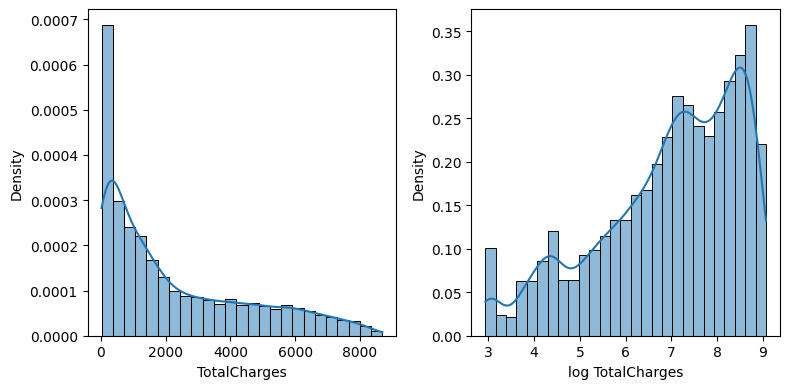

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

charges = clients["TotalCharges"]
charges_ln = np.log(charges)

# plot histogram for the charges
sns.histplot(charges, kde=True, stat="density", ax=ax[0])
ax[0].set_xlim()

# plot histogram for logarithm of the charges
sns.histplot(charges_ln, kde=True, stat="density", ax=ax[1])
ax[1].set_xlabel("log TotalCharges")

plt.tight_layout()
plt.show()

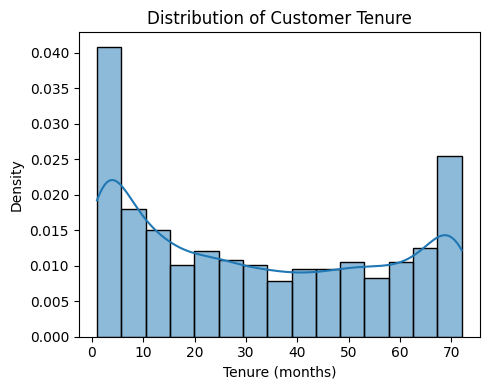

In [10]:
# Create a figure with one subplot
plt.figure(figsize=(5   , 4))

# Plot histogram for tenure with KDE
sns.histplot(data=clients, x='tenure', kde=True, stat='density')

# Customize plot
plt.title('Distribution of Customer Tenure')
plt.xlabel('Tenure (months)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

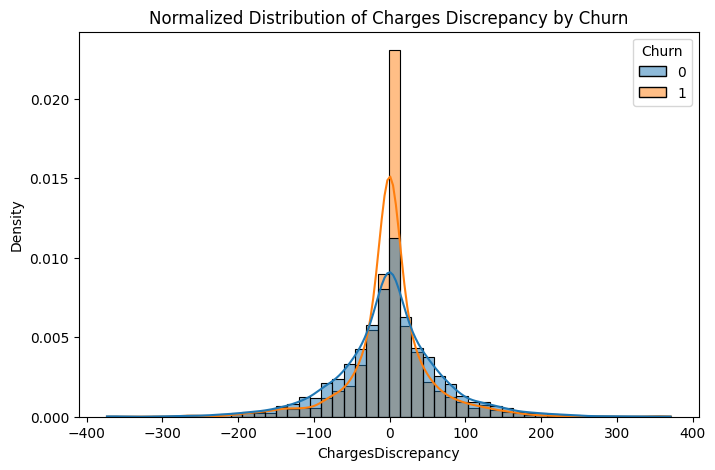

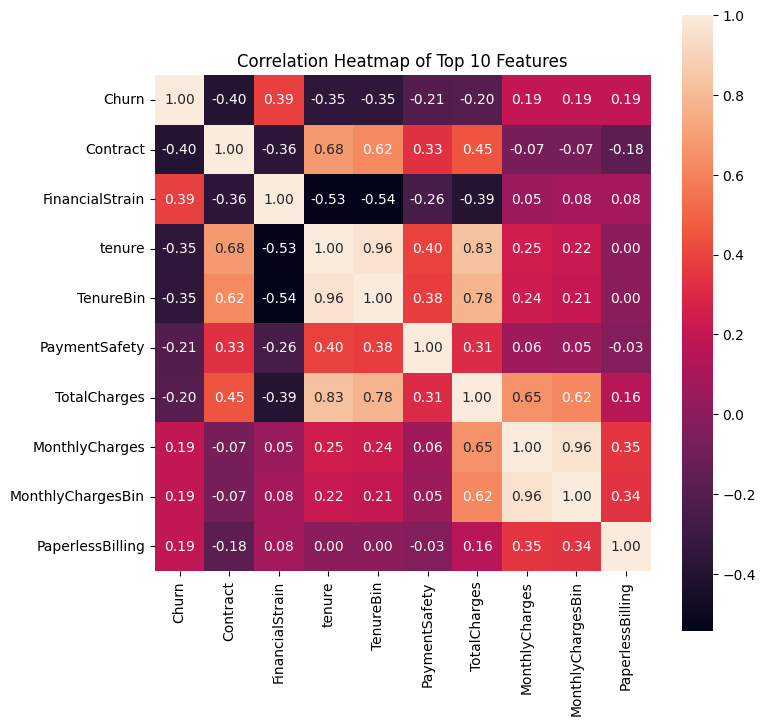

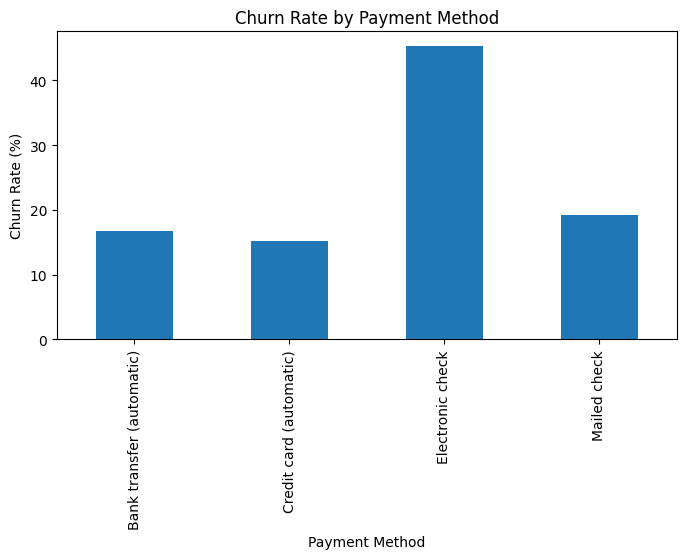

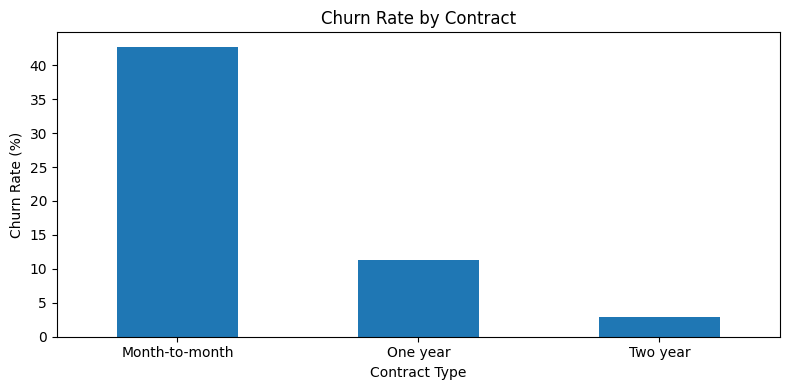

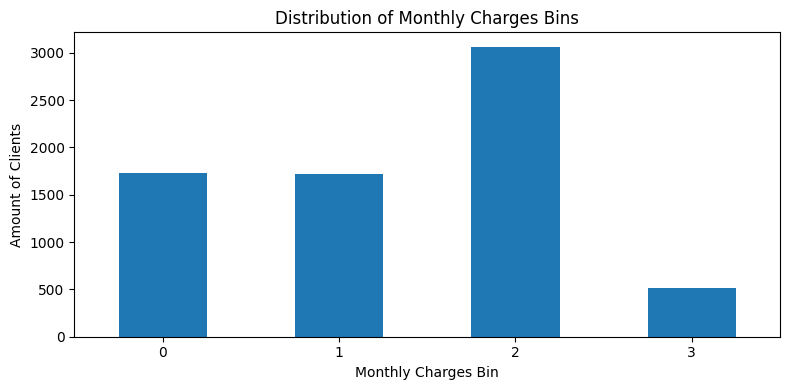

<Figure size 800x400 with 0 Axes>

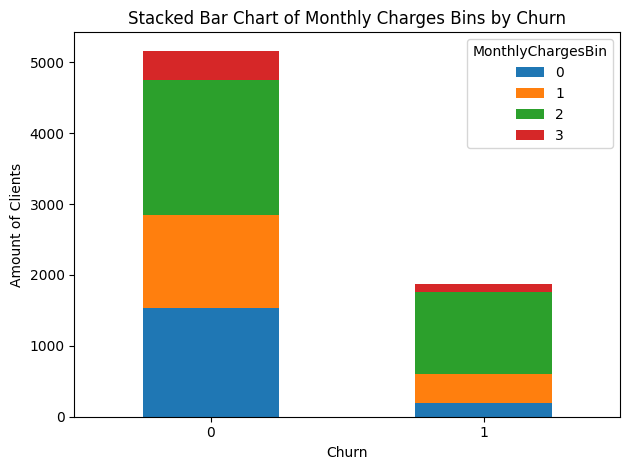

In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(data=clients, x="ChargesDiscrepancy", hue="Churn", kde=True, bins=50, stat="density", common_norm=False)
plt.title("Normalized Distribution of Charges Discrepancy by Churn")
plt.show()

correlations = clients.copy()
correlations["InternetService"] = LabelEncoder().fit_transform(correlations["InternetService"])
correlations["Contract"] = LabelEncoder().fit_transform(correlations["Contract"])
correlations["PaymentMethod"] = LabelEncoder().fit_transform(correlations["PaymentMethod"])
# compute 10 most correlated variables
cols = abs(correlations.corr()).nlargest(10, "Churn")["Churn"].index
coef = correlations[cols].corr()

# plot heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(
    data        = coef,
    xticklabels = cols.values,
    yticklabels = cols.values,
    cbar        = True,
    square      = True,
    annot       = True,
    fmt         = ".2f",
    annot_kws   = {"size": 10},
)
plt.title("Correlation Heatmap of Top 10 Features")
plt.show()

plt.figure(figsize=(8, 4))
# Ensure "Churn" is numeric before calculating the mean
original_clients["Churn"] = original_clients["Churn"].map({"Yes": 1, "No": 0})
churn_pct_by_payment = original_clients.groupby("PaymentMethod")["Churn"].mean() * 100
churn_pct_by_payment.plot(kind='bar')
plt.ylabel("Churn Rate (%)")
plt.title("Churn Rate by Payment Method")
plt.xlabel("Payment Method")
plt.xticks(rotation=90)
plt.show()

# Churn percentage by Contract
churn_by_contract = clients.groupby("Contract")["Churn"].mean() * 100

plt.figure(figsize=(8, 4))
churn_by_contract.plot(kind='bar')
plt.ylabel("Churn Rate (%)")
plt.title("Churn Rate by Contract")
plt.xlabel("Contract Type")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Distribution of Monthly Charges Bins
charges_distrib = clients["MonthlyChargesBin"].value_counts().sort_index()

plt.figure(figsize=(8, 4))
charges_distrib.plot(kind="bar", stacked=True)
plt.ylabel("Amount of Clients")
plt.title("Distribution of Monthly Charges Bins")
plt.xlabel("Monthly Charges Bin")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Stacked bar chart of Monthly Charges Bins by Churn
stack_charge_by_churn = clients["MonthlyChargesBin"].groupby(clients["Churn"]).value_counts().unstack()

plt.figure(figsize=(8, 4))
stack_charge_by_churn.plot(kind="bar", stacked=True)
plt.ylabel("Amount of Clients")
plt.title("Stacked Bar Chart of Monthly Charges Bins by Churn")
plt.xlabel("Churn")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Train, Dev, Test Dataset

Practical considerations:
- The dataset is imbalanced and to deal with this we should:
    1. Attempt to balance it
    2. Use a metric that is robust to class imbalance
- The dataset has around 7000 observation and 25 features. This implies that:
    - 60% for train = 4500
    - 20% for validation = 1200
    - 20% for test = 1200

We cannot train complex models with these numbers. I suggest we stick to:
- Logistic regression
- Bagging: Random Forest
- Boosting: XGBoost (might be too few observations)

In [12]:
import pickle
# Preprocess the remaining categorical variables for training
for col in clients.columns:
    if clients[col].dtype == "object" and clients[col].nunique() > 2:
        le = LabelEncoder()
        clients[col] = le.fit_transform(clients[col])
# save the label encoders for future use
        # with open(f"../mappings/label_encoder_{col}.pkl", "wb") as f:
        #     pickle.dump(le, f)



In [13]:
y = clients['Churn']
X = clients.drop(columns=['Churn'])
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

### Address Class Imbalance

In [14]:
print(f"Imbalance ratio (No:Yes): {round(sum(y_train==0)/sum(y_train==1), 2)}:1")
print(f"Original training shape: {X_train.shape}")

sm = SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print(f"Resampled shape: {X_train_res.shape}")
print(f"Imbalance ratio (No:Yes): {round(sum(y_train_res==0)/sum(y_train_res==1))}:1")

Imbalance ratio (No:Yes): 2.76:1
Original training shape: (4219, 28)
Resampled shape: (6196, 28)
Imbalance ratio (No:Yes): 1:1


### Train Models

In [15]:
def plot_feat_imp(feat_imp, k=10):
    """"
    Plot the top k feature importances of a model"
    """

    # Get 10 highest feature importances and corresponding column names
    feat_top = np.argsort(abs(feat_imp))[-10:]
    col_names = [X_train.columns[i] for i in feat_top]

    # plot absolute feature importances
    plt.figure(figsize=(7, 5))
    plt.barh(col_names, feat_imp[feat_top])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

def round2(x):
    return round(x, 2)

In [16]:
# Perform grid search for logistic regression on the oversampled dataset
log_reg = LogisticRegression(max_iter=1000)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid_search_lg = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search_lg.fit(X_train_res, y_train_res)

# Print the best parameters and the corresponding score
print("Best parameters:", grid_search_lg.best_params_)
print("Best F1 score:", grid_search_lg.best_score_)

Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1 score: 0.8133327801409145


In [17]:
# # Perform grid search for logistic regression on the oversampled dataset
# log_reg = LogisticRegression(max_iter=1000)
# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100],
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear']
# }
# grid_search_lg = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1', n_jobs=-1)
# grid_search_lg.fit(X, y)

# # Print the best parameters and the corresponding score
# print("Best parameters:", grid_search_lg.best_params_)
# print("Best F1 score:", grid_search_lg.best_score_)

# # Train the model with the best parameters on the full dataset
# best_log_reg = grid_search_lg.best_estimator_
# best_log_reg.fit(X, y)
# # Save the model
# with open("../models/ml_model.pkl", "wb") as f:
#     pickle.dump(best_log_reg, f)

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1032
           1       0.54      0.64      0.58       374

    accuracy                           0.76      1406
   macro avg       0.70      0.72      0.71      1406
weighted avg       0.77      0.76      0.76      1406



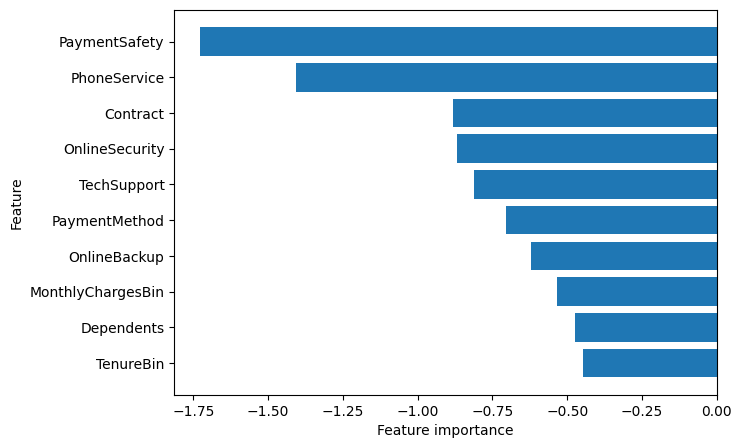

In [18]:
# Logistic regression with best parameters from grid search
best_params = grid_search_lg.best_params_
logistic_model = LogisticRegression(max_iter=1000, **best_params)
logistic_model.fit(X_train_res, y_train_res)
y_pred = logistic_model.predict(X_val)

print(classification_report(y_val, y_pred))
plot_feat_imp(logistic_model.coef_[0])

In [19]:
# Perform grid search for random forest on the oversampled dataset
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train_res, y_train_res)
# Print the best parameters and the corresponding score
print("Best parameters:", grid_search_rf.best_params_)
print("Best F1 score:", grid_search_rf.best_score_)

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 score: 0.8476219134854874


Random Forest Performance:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      1032
           1       0.56      0.57      0.56       374

    accuracy                           0.77      1406
   macro avg       0.70      0.70      0.70      1406
weighted avg       0.77      0.77      0.77      1406



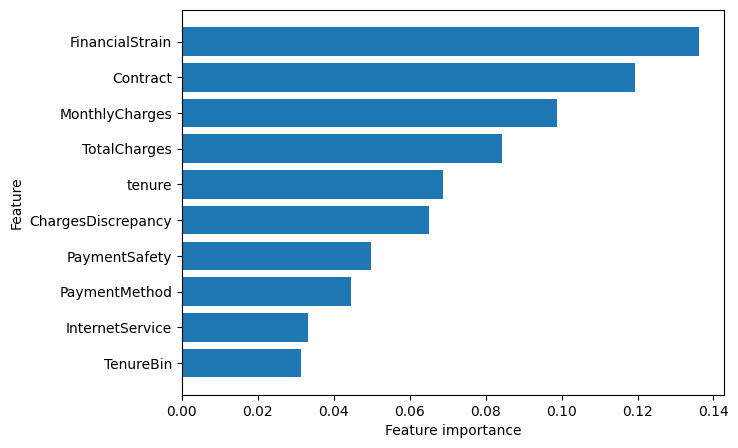

In [20]:
# Random Forest Classifier
best_params_rf = grid_search_rf.best_params_
rf_model = RandomForestClassifier(random_state=42, **best_params_rf)
rf_model.fit(X_train_res, y_train_res)
y_pred_rf = rf_model.predict(X_val)
print("Random Forest Performance:\n", classification_report(y_val, y_pred_rf))
plot_feat_imp(rf_model.feature_importances_)

In [21]:
# Perform grid search for xgboost on the oversampled dataset
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
grid_search_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search_xgb.fit(X_train_res, y_train_res)
# Print the best parameters and the corresponding score
print("Best parameters:", grid_search_xgb.best_params_)
print("Best F1 score:", grid_search_xgb.best_score_)

Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best F1 score: 0.8359898576170032


XGBoost Performance:
               precision    recall  f1-score   support

           0       0.83      0.84      0.83      1032
           1       0.54      0.52      0.53       374

    accuracy                           0.76      1406
   macro avg       0.69      0.68      0.68      1406
weighted avg       0.75      0.76      0.75      1406



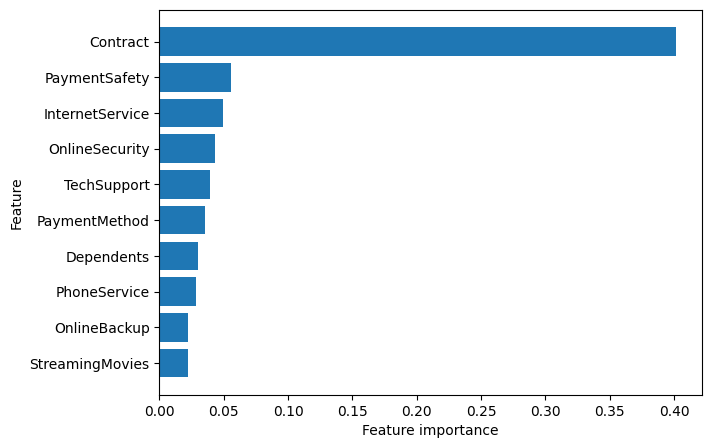

In [22]:
# XGBoost Classifier
best_params_xgb = grid_search_xgb.best_params_
xgb_model = XGBClassifier(**best_params_xgb, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_res, y_train_res)
y_pred_xgb = xgb_model.predict(X_val)
print("XGBoost Performance:\n", classification_report(y_val, y_pred_xgb))
plot_feat_imp(xgb_model.feature_importances_)

### Feature Importance analysis for XGBoost

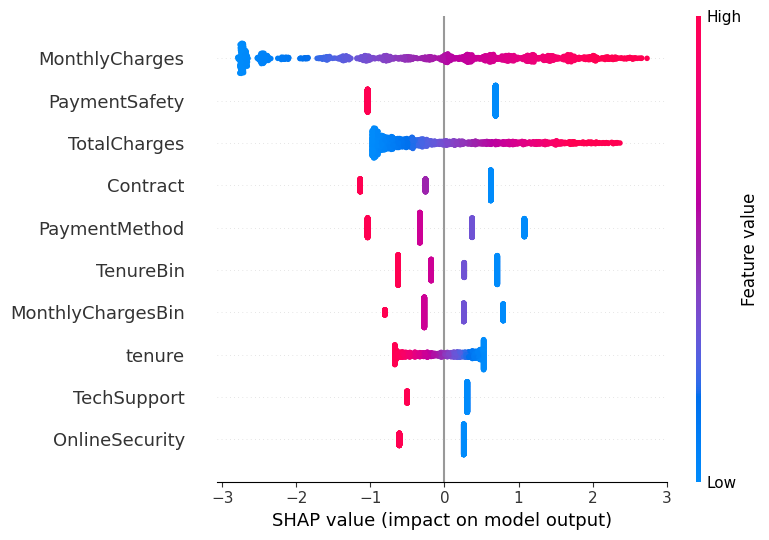

In [23]:
explainer = shap.Explainer(logistic_model, X_val)
shap_values = explainer(X_val)
shap.summary_plot(shap_values, X_val, max_display=10)

## Business Insights

### Lift Analysis on Validation Set

- Lift analysis: measure how much better the model is at identifying churners compared to random guessing
- Interpretation: at the x% of the highest predicted probabilities, the model performs y times better than random guessing
- This shows the model's effectiveness in identifying high-risk customers


Optimal threshold based on G-Mean: 0.32
AUC: 0.818


<Figure size 600x400 with 0 Axes>

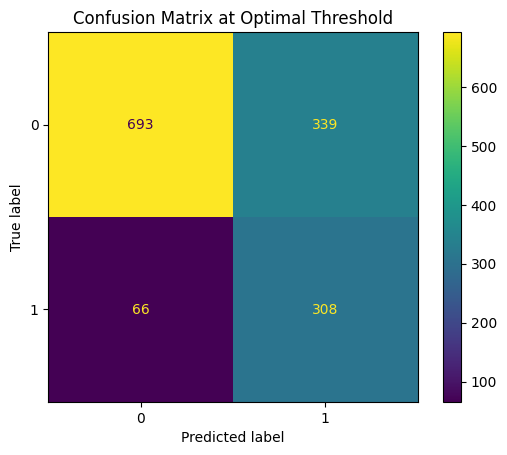

In [24]:
y_proba = logistic_model.predict_proba(X_val)[:, 1]
val_df = pd.DataFrame({"proba": y_proba, "true": y_val.values})
val_df = val_df.sort_values("proba", ascending=False).reset_index(drop=True)

# Optimal threshold tuning (maximize F1-score or net benefit)
# Using a simple 0.5 threshold would be naive and would not account for the imbalance
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)
threshold = thresholds[ix]
print(f"\nOptimal threshold based on G-Mean: {threshold:.2f}")

roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.3f}")

plt.figure(figsize=(6, 4))
ConfusionMatrixDisplay.from_predictions(y_val, y_proba > threshold)
plt.title("Confusion Matrix at Optimal Threshold")
plt.show()


In [25]:
print("\nLogistic Regression Lift Analysis on Validation Set:")
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5]
base_rate = val_df["true"].mean()

for q in quantiles:
    top_k = val_df.iloc[:int(len(val_df)*q)]
    lift = top_k["true"].mean() / base_rate
    print(f"Lift at top {int(q*100)}%: {lift:.2f}x")


Logistic Regression Lift Analysis on Validation Set:
Lift at top 10%: 2.63x
Lift at top 20%: 2.23x
Lift at top 30%: 2.05x
Lift at top 40%: 1.86x
Lift at top 50%: 1.71x


### Net benefit of the model: Validation Set

In [26]:
val_df["pred"] = (val_df["proba"] > threshold).astype(int)

# Estimate customer lifetime value
average_monthly_revenue = clients["MonthlyCharges"].mean()
average_tenure_months = clients["tenure"].mean()
customer_lifetime_value = average_monthly_revenue * average_tenure_months
print(f"\nEstimated average customer lifetime value: ${customer_lifetime_value:.2f}")

# Update costs with realistic value
retention_cost = 10
churn_cost = customer_lifetime_value

FP = ((val_df["pred"] == 1) & (val_df["true"] == 0)).sum()
FN = ((val_df["pred"] == 0) & (val_df["true"] == 1)).sum()
TP = ((val_df["pred"] == 1) & (val_df["true"] == 1)).sum()

# Customers predicted to churn but not actually churned -> useless cost of retention
false_positive_cost = FP * retention_cost

# Customers predicted to not churn but actually churned -> lost revenue
false_negative_cost = FN * churn_cost

# Customers predicted to churn and actually churned -> value of prevented churns
true_positive_value = TP * (churn_cost - retention_cost)

net_benefit = true_positive_value - false_positive_cost - false_negative_cost
print("\nBusiness Impact (fixed retention cost - validation):")
print(f"Cost of unnecessary retention actions: ${false_positive_cost:.2f}")
print(f"Cost of missed churns: ${false_negative_cost:.2f}")
print(f"Value of prevented churns: ${true_positive_value:.2f}")
print(f"Net benefit: ${net_benefit:.2f}")


Estimated average customer lifetime value: $2100.87

Business Impact (fixed retention cost - validation):
Cost of unnecessary retention actions: $3390.00
Cost of missed churns: $138657.66
Value of prevented churns: $643989.08
Net benefit: $501941.42


In [27]:
# Use the pre-calculated retention cost directly for the validation set
val_df["retention_cost"] = 0.05 * clients.loc[X_val.index, "MonthlyCharges"].values * 6
val_df["churn_cost"] = customer_lifetime_value

false_positive_cost = val_df.loc[(val_df["pred"] == 1) & (val_df["true"] == 0), "retention_cost"].sum()
false_negative_cost = val_df.loc[(val_df["pred"] == 0) & (val_df["true"] == 1), "churn_cost"].sum()
true_positive_value = val_df.loc[(val_df["pred"] == 1) & (val_df["true"] == 1), "churn_cost"].sum() - \
                      val_df.loc[(val_df["pred"] == 1) & (val_df["true"] == 1), "retention_cost"].sum()

net_benefit = true_positive_value - false_positive_cost - false_negative_cost
print("\nBusiness Impact (estimated retention cost - validation):")
print(f"Cost of unnecessary retention actions: ${false_positive_cost:.2f}")
print(f"Cost of missed churns: ${false_negative_cost:.2f}")
print(f"Value of prevented churns: ${true_positive_value:.2f}")
print(f"Net benefit: ${net_benefit:.2f}")



Business Impact (estimated retention cost - validation):
Cost of unnecessary retention actions: $6678.35
Cost of missed churns: $138657.66
Value of prevented churns: $641161.65
Net benefit: $495825.64


### Lift Analysis on Test Set


Optimal threshold based on G-Mean: 0.40
AUC: 0.845


<Figure size 600x400 with 0 Axes>

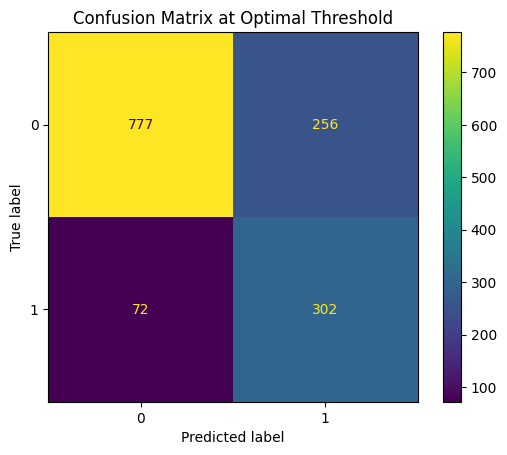

In [28]:
y_proba = logistic_model.predict_proba(X_test)[:, 1]
test_df = pd.DataFrame({"proba": y_proba, "true": y_test.values})
test_df = test_df.sort_values("proba", ascending=False).reset_index(drop=True)

# Optimal threshold tuning (maximize F1-score or net benefit)
# Using a simple 0.5 threshold would be naive and would not account for the imbalance
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)
threshold = thresholds[ix]
print(f"\nOptimal threshold based on G-Mean: {threshold:.2f}")

roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.3f}")

plt.figure(figsize=(6, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_proba > threshold)
plt.title("Confusion Matrix at Optimal Threshold")
plt.show()


In [29]:
print("\nLogistic Regression Lift Analysis on Validation Set:")
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5]
base_rate = test_df["true"].mean()

for q in quantiles:
    top_k = test_df.iloc[:int(len(test_df)*q)]
    lift = top_k["true"].mean() / base_rate
    print(f"Lift at top {int(q*100)}%: {lift:.2f}x")


Logistic Regression Lift Analysis on Validation Set:
Lift at top 10%: 2.90x
Lift at top 20%: 2.49x
Lift at top 30%: 2.22x
Lift at top 40%: 2.03x
Lift at top 50%: 1.76x


### Net benefit of the model: Test Set

In [30]:
test_df["pred"] = (test_df["proba"] > threshold).astype(int)

# Estimate customer lifetime value
average_monthly_revenue = clients["MonthlyCharges"].mean()
average_tenure_months = clients["tenure"].mean()
customer_lifetime_value = average_monthly_revenue * average_tenure_months
print(f"\nEstimated average customer lifetime value: ${customer_lifetime_value:.2f}")

# Assume a retention cost of $10 per customer
retention_cost = 10
churn_cost = customer_lifetime_value

FP = ((test_df["pred"] == 1) & (test_df["true"] == 0)).sum()
FN = ((test_df["pred"] == 0) & (test_df["true"] == 1)).sum()
TP = ((test_df["pred"] == 1) & (test_df["true"] == 1)).sum()

# Customers predicted to churn but not actually churned -> useless cost of retention
false_positive_cost = FP * retention_cost

# Customers predicted to not churn but actually churned -> lost revenue
false_negative_cost = FN * churn_cost

# Customers predicted to churn and actually churned -> value of prevented churns
true_positive_value = TP * (churn_cost - retention_cost)

net_benefit = true_positive_value - false_positive_cost - false_negative_cost
print("\nBusiness Impact (fixed retention cost - test):")
print(f"Cost of unnecessary retention actions: ${false_positive_cost:.2f}")
print(f"Cost of missed churns: ${false_negative_cost:.2f}")
print(f"Value of prevented churns: ${true_positive_value:.2f}")
print(f"Net benefit: ${net_benefit:.2f}")



Estimated average customer lifetime value: $2100.87

Business Impact (fixed retention cost - test):
Cost of unnecessary retention actions: $2560.00
Cost of missed churns: $151262.90
Value of prevented churns: $631443.84
Net benefit: $477620.94


In [31]:
# Use the pre-calculated retention cost directly
test_df["retention_cost"] = 0.05 * clients.loc[X_test.index, "MonthlyCharges"].values * 6
test_df["churn_cost"] = customer_lifetime_value

false_positive_cost = test_df.loc[(test_df["pred"] == 1) & (test_df["true"] == 0), "retention_cost"].sum()
false_negative_cost = test_df.loc[(test_df["pred"] == 0) & (test_df["true"] == 1), "churn_cost"].sum()
true_positive_value = test_df.loc[(test_df["pred"] == 1) & (test_df["true"] == 1), "churn_cost"].sum() - \
                      test_df.loc[(test_df["pred"] == 1) & (test_df["true"] == 1), "retention_cost"].sum()

net_benefit = true_positive_value - false_positive_cost - false_negative_cost
print("\nBusiness Impact (estimated retention cost - test):")
print(f"Cost of unnecessary retention actions: ${false_positive_cost:.2f}")
print(f"Cost of missed churns: ${false_negative_cost:.2f}")
print(f"Value of prevented churns: ${true_positive_value:.2f}")
print(f"Net benefit: ${net_benefit:.2f}")



Business Impact (estimated retention cost - test):
Cost of unnecessary retention actions: $4934.20
Cost of missed churns: $151262.90
Value of prevented churns: $628418.45
Net benefit: $472221.34


### Targeted Segments for Retention

Divide high-risk customers (above the estimated threshold) into 4 segments beased on the predicted  probability of churn. \
This could allow for tailored retention strategies based on risk level

In [32]:
val_df["customer_id"] = X_val.index
high_risk_val = val_df[val_df["proba"] > threshold].copy()
high_risk_val["risk_segment"] = pd.qcut(high_risk_val["proba"], q=4, labels=["Medium", "High", "Very High", "Critical"])

print("\nSample of High-Risk Customers by Risk Segment (Validation):")
print(high_risk_val[["customer_id", "proba", "risk_segment"]].head())


Sample of High-Risk Customers by Risk Segment (Validation):
  customer_id     proba risk_segment
0  9878-TNQGW  0.973765     Critical
1  2720-WGKHP  0.973218     Critical
2  7244-KXYZN  0.972913     Critical
3  7306-YDSOI  0.970400     Critical
4  0015-UOCOJ  0.969396     Critical


In [33]:
test_df["customer_id"] = X_test.index
high_risk_test = test_df[test_df["proba"] > threshold].copy()
high_risk_test["risk_segment"] = pd.qcut(high_risk_test["proba"], q=4, labels=["Medium", "High", "Very High", "Critical"])

print("\nSample of High-Risk Customers by Risk Segment (Testing):")
print(high_risk_test[["customer_id", "proba", "risk_segment"]].head())


Sample of High-Risk Customers by Risk Segment (Testing):
  customer_id     proba risk_segment
0  3011-WQKSZ  0.972614     Critical
1  6817-WTYHE  0.972107     Critical
2  6654-QGBZZ  0.971654     Critical
3  3638-WEABW  0.970488     Critical
4  6821-BUXUX  0.969734     Critical
